# DC GAN(Deep Convolutional GAN)

In [1]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, BatchNormalization, MaxPool2D
from tensorflow.keras.layers import Reshape, Conv2D, Conv2DTranspose, Flatten, Activation
from tensorflow.keras.models import Model,Sequential

# I. Load MNIST Dataset

* Normalization and Reshape

In [3]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
    
# Normalization: -1 ~ 1 Range
X_train = (X_train.astype(float) - 127.5) / 127.5
    
# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)

11490434/11490434 [==============================] - 1s 0us/step


# II. 'generator' Model

* 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력받아 이미지 생성
 - NOISE_DIM : 입력 랜덤 벡터 크기
* 'discriminator'를 속이도록 학습
 - 'Real Image'와 같은 'Fake Image' 생성이 목적

In [4]:
NOISE_DIM = 10

generator = Sequential(name = 'generator')

generator.add(Dense(256 * 7 * 7, input_shape = (NOISE_DIM,)))
generator.add(LeakyReLU())
# 12544
generator.add(Reshape((7, 7, 256)))
# (14, 14, 128) 25088
generator.add(Conv2DTranspose(filters = 128, 
                              kernel_size = (3, 3), 
                              strides = (2, 2), 
                              padding = 'same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
# (28, 28, 64) 50176
generator.add(Conv2DTranspose(filters = 128, 
                              kernel_size = (3, 3), 
                              strides = (2, 2), 
                              padding = 'same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
# (28, 28, 1)
generator.add(Conv2D(filters = 1, 
                     kernel_size = (3, 3), 
                     padding = 'same'))
generator.add(Activation('tanh'))

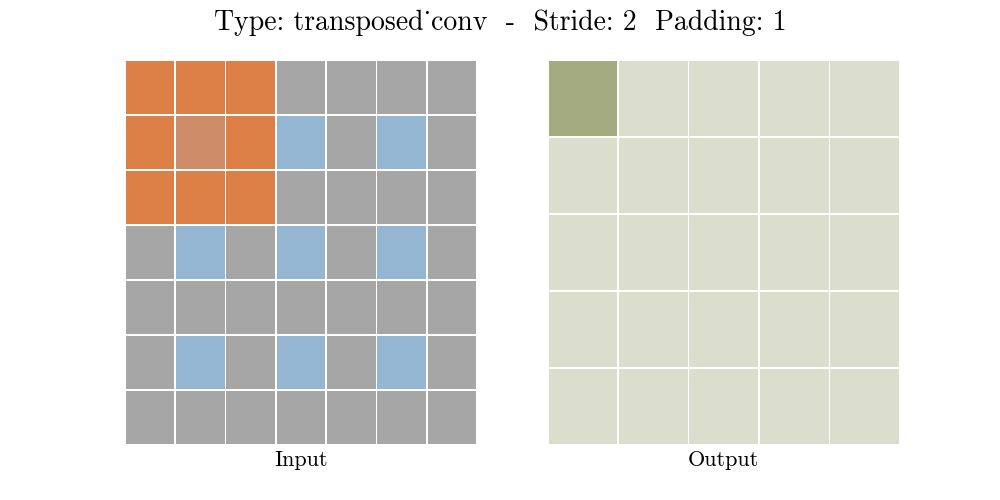

* Model Summary

In [5]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             137984    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      295040    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0 

# III. 'discriminator' Model

* 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image' 인지 판별
 - 이진분류

In [6]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminator')

discriminator.add(Conv2D(filters = 32, 
                         kernel_size = (3, 3), 
                         strides = (1, 1), 
                         padding = 'valid', 
                         input_shape = (28, 28, 1)))
discriminator.add(LeakyReLU())
discriminator.add(MaxPool2D(pool_size = (2, 2)))
discriminator.add(Conv2D(filters = 64, 
                         kernel_size = (3, 3), 
                         strides = (1, 1), 
                         padding = 'valid'))
discriminator.add(LeakyReLU())
discriminator.add(MaxPool2D(pool_size = (2, 2)))
discriminator.add(Conv2D(filters = 128, 
                         kernel_size = (3, 3), 
                         strides = (1, 1), 
                         padding = 'valid'))
discriminator.add(LeakyReLU())
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))

* Model Summary

In [7]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 11, 11, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                 

> ## 1) 'discriminator' Compile

* 학습 설정

In [8]:
from tensorflow.keras.optimizers import Adam

discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(lr = 0.0002, 
                                       beta_1 = 0.5))

# IV. 'gan' Model

> ## 1) 'generator', 'discriminator' 연결

* 'gan' 모델에서 'generator'만 학습하도록 설정
 - discriminator.trainable = False

In [9]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

> ## 2) 'gan' Model

In [10]:
gan = Model(gan_input, output, name = 'gan')

> ## 3) 'gan' Summary

In [11]:
gan.summary()

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 generator (Sequential)      (None, 28, 28, 1)         582785    
                                                                 
 discriminator (Sequential)  (None, 1)                 93825     
                                                                 
Total params: 676,610
Trainable params: 582,273
Non-trainable params: 94,337
_________________________________________________________________


> ## 4) 'gan' Compile

* 학습 설정

In [12]:
gan.compile(loss = 'binary_crossentropy', 
            optimizer = Adam(lr = 0.0002, 
                             beta_1 = 0.5))

# V. Define 'get_batches( )' Function

* MNIST image batch 생성

In [13]:
def get_batches(data, batch_size):
    batches = []

    for i in range(data.shape[0] // batch_size):
        batch = data[i * batch_size : (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

# VI. 'visualize_training( )' Function

In [14]:
def visualize_training(epoch, d_losses, g_losses):

    # 오차 시각화
    # plt.figure(figsize=(8, 4))
    # plt.plot(d_losses, label='Discriminator Loss')
    # plt.plot(g_losses, label='Generatror Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()
    # print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    # 이미지 생성 결과 시각화
    print('epoch :', epoch)
    noise = np.random.normal(0, 1, size = (24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize = (8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# VII. Define Loss

In [15]:
# loss_function = keras.losses.BinaryCrossentropy()

# train_loss = keras.metrics.BinaryCrossentropy(name = 'train_loss')
# train_accuracy = keras.metrics.BinaryAccuracy(name = 'train_accuracy')

# VIII. Model Training

* 약 35분
<br>
<br>
* .fit( )
 - 'epoch', 'batch_size' 지정
* .train_on_batch( )
 - 전달 받은 모든 데이터를 사용하여 학습 진행
* 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch( )' 사용

epoch : 1
1/1 [==============================] - 0s 138ms/step


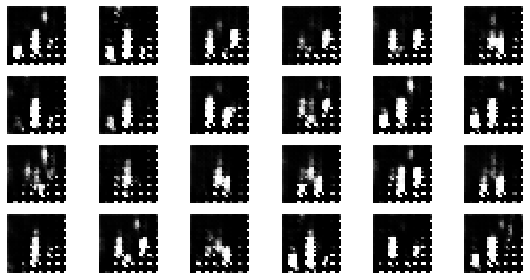

epoch : 5
1/1 [==============================] - 0s 14ms/step


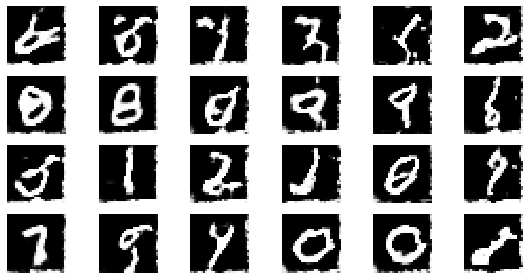

epoch : 10
1/1 [==============================] - 0s 14ms/step


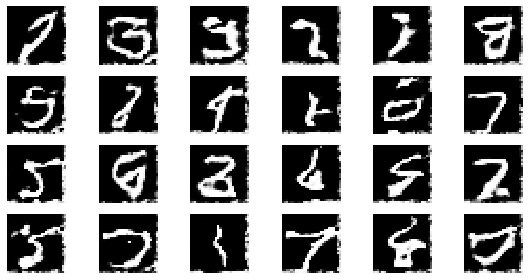

epoch : 15
1/1 [==============================] - 0s 16ms/step


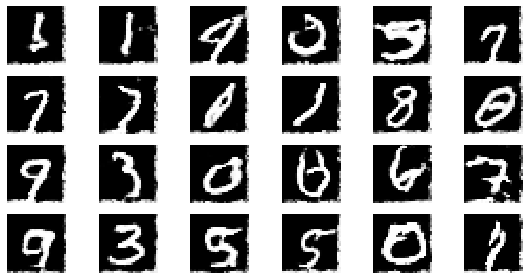

epoch : 20
1/1 [==============================] - 0s 17ms/step


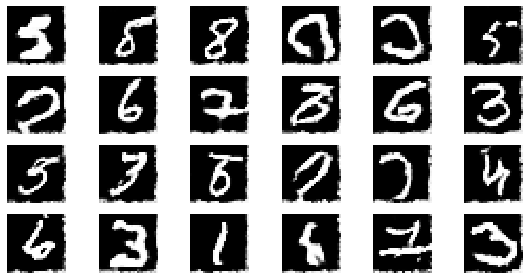

epoch : 25
1/1 [==============================] - 0s 14ms/step


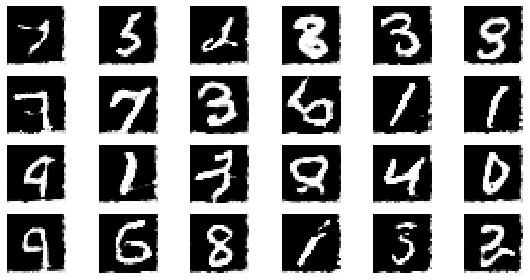

epoch : 30
1/1 [==============================] - 0s 14ms/step


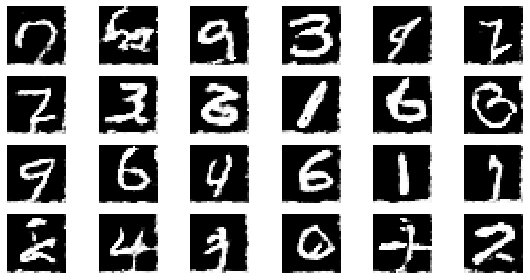

epoch : 35
1/1 [==============================] - 0s 15ms/step


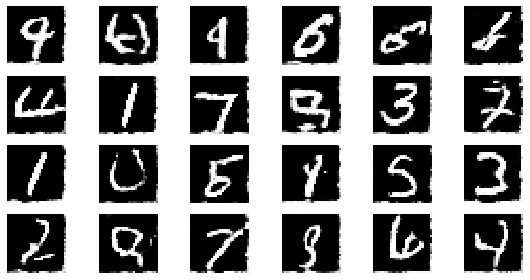

epoch : 40
1/1 [==============================] - 0s 15ms/step


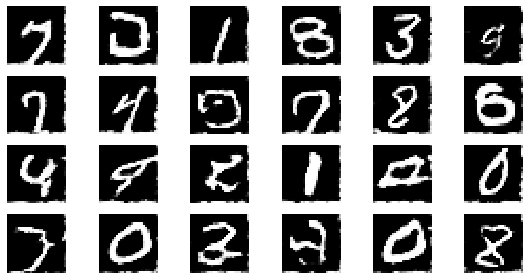

epoch : 45
1/1 [==============================] - 0s 17ms/step


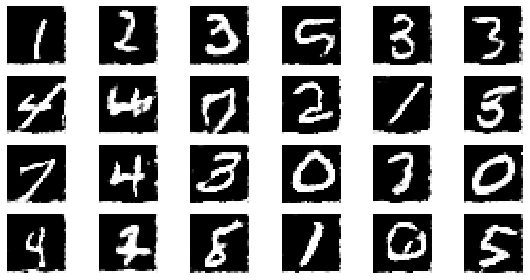

epoch : 50
1/1 [==============================] - 0s 15ms/step


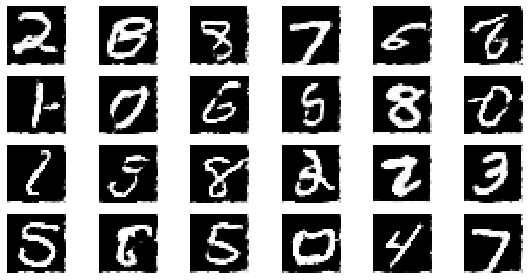

CPU times: user 30min 47s, sys: 1min 14s, total: 32min 1s
Wall time: 33min 55s


In [16]:
%%time

EPOCHS = 50
BATCH_SIZE = 128

# 'discriminator', 'gan' Loss 저장 List
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # batch 별 학습
    for real_images in get_batches(X_train, BATCH_SIZE):
        # Random Noise 생성
        input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        
        # Fake Image 데이터 생성
        generated_images = generator.predict(input_noise, verbose = 0)
        
        # 'gan' 학습용 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # 'gan' 학습용 y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 1
        
        # 'discriminator' 학습
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # 'gan' 학습
        noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # 'discriminator' 학습 정지
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # 생성 결과 시각화
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)

# 
# 
# 
# The End
# 
# 
# 